In [334]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.simplefilter('ignore')

In [335]:
country_demo=pd.read_csv("demographics/country_demographics.csv")
country_demo.head()


,Unnamed: 0,Country_Region,Population Density (per sq. km),HDI,Total Testing,hospibed,pop,Age Dependency Ratio (65+/Working Age),Physician_per_thousand,Lockdown Date
0,0,Afghanistan,56.937760,0.498,NaN,0.5,38928346.0,4.763323,0.3039,24/03/2020
1,74,Albania,104.612263,0.785,NaN,2.9,2877797.0,18.997890,1.6500,08/03/2020
2,148,Algeria,17.730075,0.754,NaN,1.9,43851044.0,9.628361,1.8300,24/03/2020
3,222,Andorra,163.842553,0.858,NaN,2.5,77265.0,NaN,4.0000,16/03/2020
4,296,Angola,24.713052,0.581,NaN,NaN,NaN,4.734531,0.2149,24/03/2020


In [336]:
classi_data = country_demo.drop(['Total Testing','Lockdown Date','pop','Unnamed: 0'], axis = 1)
classi_data[classi_data.isnull().any(axis=1)]

,Country_Region,Population Density (per sq. km),HDI,hospibed,Age Dependency Ratio (65+/Working Age),Physician_per_thousand
3,Andorra,163.842553,0.858,2.5,NaN,4.0000
4,Angola,24.713052,0.581,NaN,4.734531,0.2149
22,Botswana,3.977425,0.717,NaN,6.096089,0.4065
28,Burundi,435.178271,0.417,NaN,4.885961,0.0590
29,Cabo Verde,134.929777,0.654,2.1,NaN,0.7694
47,Diamond Princess,NaN,NaN,13.4,NaN,NaN
55,Eritrea,31.821505,0.440,0.7,NaN,0.0557
57,Eswatini,66.057616,0.588,0.8,NaN,0.1668
74,Holy See,NaN,NaN,5.0,NaN,NaN
91,Kosovo,168.154680,NaN,6.7,NaN,NaN


In [337]:
#we will get rid of any country that has an NAN value for now. These data can be added later.
classi_data_noNA = classi_data.dropna()
classi_data_noNA = classi_data_noNA.drop_duplicates()
classi_data_noNA = classi_data_noNA.reset_index(drop=True)
classi_data_noNA

classi_data_n = pd.DataFrame(classi_data_noNA[['Population Density (per sq. km)','HDI','Age Dependency Ratio (65+/Working Age)','Physician_per_thousand']])
classi_data_n.head()


,Population Density (per sq. km),HDI,Age Dependency Ratio (65+/Working Age),Physician_per_thousand
0,56.937760,0.498,4.763323,0.3039
1,104.612263,0.785,18.997890,1.6500
2,17.730075,0.754,9.628361,1.8300
3,218.831818,0.780,10.021966,3.0300
4,16.258510,0.825,17.520504,3.9600


In [338]:
classi_data_noNA.to_csv("demographics/country_demographics_for_classification.csv")

In [339]:
#standardize the data to normal distribution
from sklearn import preprocessing
data_standadized= preprocessing.scale(classi_data_n)
data_standadized = pd.DataFrame(data_standadized)

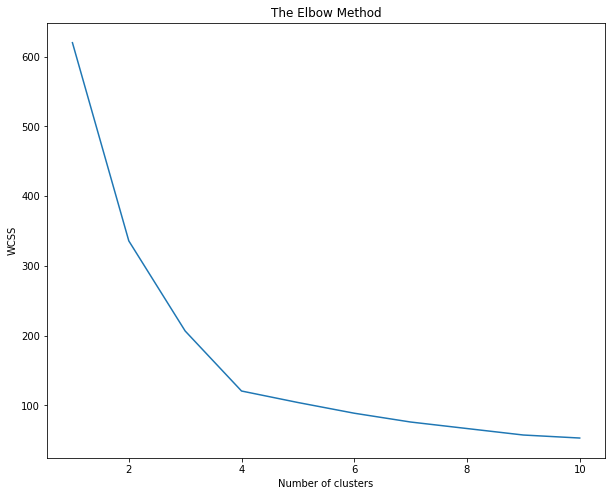

In [340]:
# find the appropriate cluster number
plt.figure(figsize=(10, 8))
from sklearn.cluster import KMeans
wcss = []
def k_means_find_n_cluster(data):
    for i in range(1, 11):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
k_means_find_n_cluster(data_standadized)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()
#WCSS is the sum of squares of the distances of each data point in all clusters to their respective centroids.
#we should use the number that adding one more cluster wouldn't change much in terms of WCSS
#code reference: https://medium.com/datadriveninvestor/unsupervised-learning-with-python-k-means-and-hierarchical-clustering-f36ceeec919c

In [341]:
def fit_k_means (data, original_data):
# Fitting K-Means to the dataset
    kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
    y_kmeans = kmeans.fit_predict(data)
#beginning of  the cluster numbering with 1 instead of 0
    y_kmeans1=y_kmeans
    y_kmeans1=y_kmeans+1
# New Dataframe called cluster
    cluster = pd.DataFrame(y_kmeans1)
# Adding cluster to the Dataset1
    original_data['cluster'] = cluster
#Mean of clusters
fit_k_means(data_standadized,classi_data_noNA)



In [342]:
def k_means_cluster_info (original_data):
    kmeans_mean_cluster = pd.DataFrame(round(original_data.groupby('cluster').mean(),1))
    return kmeans_mean_cluster
k_means_cluster_info(classi_data_noNA)

,Population Density (per sq. km),HDI,hospibed,Age Dependency Ratio (65+/Working Age),Physician_per_thousand
cluster,,,,,
1,120.2,0.5,1.0,6.0,0.3
2,194.5,0.8,2.6,9.8,1.9
3,171.1,0.9,5.2,26.5,3.9
4,7953.0,0.9,2.4,17.9,2.3


In [343]:
classi_data_noNA

,Country_Region,Population Density (per sq. km),HDI,hospibed,Age Dependency Ratio (65+/Working Age),Physician_per_thousand,cluster
0,Afghanistan,56.937760,0.498,0.5,4.763323,0.3039,1
1,Albania,104.612263,0.785,2.9,18.997890,1.6500,2
2,Algeria,17.730075,0.754,1.9,9.628361,1.8300,2
3,Antigua and Barbuda,218.831818,0.780,3.8,10.021966,3.0300,2
4,Argentina,16.258510,0.825,5.0,17.520504,3.9600,3
...,...,...,...,...,...,...,...
150,Uzbekistan,77.469205,0.710,4.0,6.616023,3.4250,2
151,Venezuela,32.730792,0.761,0.8,10.053507,1.9400,2
152,Vietnam,308.125246,0.694,2.6,10.244811,1.1800,2
153,Zambia,23.341479,0.588,2.0,4.701905,0.1632,1


In [344]:
classi_data_noNA[classi_data_noNA.isnull().any(axis=1)]
#we have a couple countries that don't have a group. we'll drop them for now

,Country_Region,Population Density (per sq. km),HDI,hospibed,Age Dependency Ratio (65+/Working Age),Physician_per_thousand,cluster


In [345]:

cluster_result = classi_data_noNA.sort_values(by=['cluster','Country_Region'])
cluster_result

,Country_Region,Population Density (per sq. km),HDI,hospibed,Age Dependency Ratio (65+/Working Age),Physician_per_thousand,cluster
0,Afghanistan,56.937760,0.498,0.5,4.763323,0.3039,1
11,Bangladesh,1239.579312,0.608,0.8,7.662842,0.5268,1
16,Benin,101.853920,0.515,0.5,5.998464,0.1646,1
17,Bhutan,19.777528,0.612,1.7,7.124089,0.3748,1
23,Burkina Faso,72.191283,0.423,0.4,4.595743,0.0600,1
...,...,...,...,...,...,...,...
149,US,35.766089,0.924,2.9,23.469613,2.9401,3
145,Ukraine,77.029667,0.751,8.8,24.192400,4.4070,3
147,United Kingdom,274.827392,0.922,2.8,29.036791,2.8058,3
148,Uruguay,19.708028,0.804,2.8,22.796753,5.0499,3


In [386]:
group_1 = cluster_result.loc[(cluster_result['cluster'] == 1)]
group_1.to_csv("group_1.csv")
group_1

,Country_Region,Population Density (per sq. km),HDI,hospibed,Age Dependency Ratio (65+/Working Age),Physician_per_thousand,cluster
0,Afghanistan,56.937760,0.498,0.5000,4.763323,0.3039,1
11,Bangladesh,1239.579312,0.608,0.8000,7.662842,0.5268,1
16,Benin,101.853920,0.515,0.5000,5.998464,0.1646,1
17,Bhutan,19.777528,0.612,1.7000,7.124089,0.3748,1
23,Burkina Faso,72.191283,0.423,0.4000,4.595743,0.0600,1
24,Burma,82.238615,0.578,0.9000,8.499201,0.8640,1
25,Cambodia,92.056413,0.582,0.8000,6.861080,0.4759,1
26,Cameroon,53.343989,0.556,1.3000,5.849213,0.1842,1
28,Central African Republic,7.490412,0.367,1.0000,6.876590,0.0816,1
29,Chad,12.291734,0.404,0.4000,4.934994,0.0475,1


In [387]:
group_2 = cluster_result.loc[(cluster_result['cluster'] == 2)]
group_2.to_csv("group_2.csv")
group_2

,Country_Region,Population Density (per sq. km),HDI,hospibed,Age Dependency Ratio (65+/Working Age),Physician_per_thousand,cluster
1,Albania,104.612263,0.785,2.9,18.997890,1.6500,2
2,Algeria,17.730075,0.754,1.9,9.628361,1.8300,2
3,Antigua and Barbuda,218.831818,0.780,3.8,10.021966,3.0300,2
8,Azerbaijan,120.265320,0.757,4.7,8.511162,3.9900,2
9,Bahamas,38.525475,0.807,2.9,12.750961,2.7158,2
...,...,...,...,...,...,...,...
143,Turkey,106.960129,0.791,2.7,12.187896,1.7651,2
146,United Arab Emirates,135.609110,0.863,1.2,1.346261,2.3944,2
150,Uzbekistan,77.469205,0.710,4.0,6.616023,3.4250,2
151,Venezuela,32.730792,0.761,0.8,10.053507,1.9400,2


In [384]:
group_3 = cluster_result.loc[(cluster_result['cluster'] == 3)]
group_3.to_csv("group_3.csv")
group_3

,Country_Region,Population Density (per sq. km),HDI,hospibed,Age Dependency Ratio (65+/Working Age),Physician_per_thousand,cluster
4,Argentina,16.258510,0.825,5.0,17.520504,3.9600,3
5,Armenia,103.680225,0.755,4.2,16.335559,3.9240,3
6,Australia,3.249129,0.939,3.8,23.675413,3.5874,3
7,Austria,107.206927,0.908,7.6,28.784953,5.1441,3
12,Barbados,666.606977,0.800,5.8,22.659093,2.4886,3
13,Belarus,46.728800,0.808,11.0,21.617685,4.9800,3
14,Belgium,377.214927,0.916,6.2,28.866310,3.9000,3
19,Bosnia and Herzegovina,64.920488,0.768,3.5,23.908613,2.0003,3
22,Bulgaria,64.703537,0.813,6.8,32.019888,3.9879,3
27,Canada,4.075308,0.926,2.7,25.353319,2.6102,3


In [385]:
group_4 = cluster_result.loc[(cluster_result['cluster'] == 4)]
group_4.to_csv("group_4.csv")
group_4

,Country_Region,Population Density (per sq. km),HDI,hospibed,Age Dependency Ratio (65+/Working Age),Physician_per_thousand,cluster
128,Singapore,7952.998418,0.932,2.4,17.922595,2.3063,4


In [350]:
country_demographics_date = pd.read_csv("demographics/country_demographics_by_date.csv")

In [351]:
clusters = cluster_result[['Country_Region','cluster']]
country_demographics_date= country_demographics_date.merge(clusters, on=['Country_Region'], how='left')
country_demographics_date = country_demographics_date.sort_values(by='Date')
country_demographics_date

,Unnamed: 0,Unnamed: 0.1,i,Country_Region,Date,ConfirmedCases,Population Density (per sq. km),HDI,Testing By Date,Total Testing,Age Dependency Ratio (65+/Working Age),Physician_per_thousand,hospibed,pop,Lockdown Date,cluster
0,0,0,0,Afghanistan,2020-01-22,0,56.937760,0.498,NaN,NaN,4.763323,0.3039,0.5,38928346.0,24/03/2020,1.0
3478,3478,3478,6352,Diamond Princess,2020-01-22,0,NaN,NaN,NaN,NaN,NaN,NaN,13.4,3500.0,NaN,NaN
592,592,592,5259,Australia,2020-01-22,0,3.249129,0.939,NaN,113615.0,23.675413,3.5874,3.8,25499884.0,24/03/2020,3.0
5920,5920,5920,98,Iran,2020-01-22,0,50.222420,0.798,NaN,80000.0,7.675249,1.4862,1.5,83992949.0,15/03/2020,2.0
10730,10730,10730,173,Serbia,2020-01-22,0,79.831740,0.787,NaN,NaN,26.240448,3.1250,5.7,8737371.0,15/03/2020,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8509,8509,8509,12480,Morocco,2020-04-04,919,80.728519,0.667,NaN,NaN,10.281501,0.7273,1.1,36910560.0,16/03/2020,2.0
8435,8435,8435,11629,Montenegro,2020-04-04,201,46.271004,0.814,NaN,NaN,21.993514,2.3337,4.0,628066.0,24/03/2020,3.0
8361,8361,8361,9777,Mongolia,2020-04-04,14,2.040609,0.741,NaN,NaN,6.079691,3.2426,7.0,3278290.0,10/03/2020,2.0
6511,6511,6511,11926,Jordan,2020-04-04,323,112.142498,0.735,NaN,NaN,6.278502,2.8407,1.4,10203134.0,21/03/2020,2.0


In [352]:
import datetime as dt
country_demographics_date["Lockdown Date"] = country_demographics_date["Lockdown Date"].map(lambda x:pd.to_datetime(x,format='%d/%m/%Y'), na_action='ignore')
country_demographics_date['time to lockdown'] = pd.to_datetime(country_demographics_date["Date"]) - country_demographics_date["Lockdown Date"]
country_demographics_date['time to lockdown'] = country_demographics_date['time to lockdown'] / np.timedelta64(1, 'D')
country_demographics_date


,Unnamed: 0,Unnamed: 0.1,i,Country_Region,Date,ConfirmedCases,Population Density (per sq. km),HDI,Testing By Date,Total Testing,Age Dependency Ratio (65+/Working Age),Physician_per_thousand,hospibed,pop,Lockdown Date,cluster,time to lockdown
0,0,0,0,Afghanistan,2020-01-22,0,56.937760,0.498,NaN,NaN,4.763323,0.3039,0.5,38928346.0,2020-03-24,1.0,-62.0
3478,3478,3478,6352,Diamond Princess,2020-01-22,0,NaN,NaN,NaN,NaN,NaN,NaN,13.4,3500.0,NaT,NaN,NaN
592,592,592,5259,Australia,2020-01-22,0,3.249129,0.939,NaN,113615.0,23.675413,3.5874,3.8,25499884.0,2020-03-24,3.0,-62.0
5920,5920,5920,98,Iran,2020-01-22,0,50.222420,0.798,NaN,80000.0,7.675249,1.4862,1.5,83992949.0,2020-03-15,2.0,-53.0
10730,10730,10730,173,Serbia,2020-01-22,0,79.831740,0.787,NaN,NaN,26.240448,3.1250,5.7,8737371.0,2020-03-15,3.0,-53.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8509,8509,8509,12480,Morocco,2020-04-04,919,80.728519,0.667,NaN,NaN,10.281501,0.7273,1.1,36910560.0,2020-03-16,2.0,19.0
8435,8435,8435,11629,Montenegro,2020-04-04,201,46.271004,0.814,NaN,NaN,21.993514,2.3337,4.0,628066.0,2020-03-24,3.0,11.0
8361,8361,8361,9777,Mongolia,2020-04-04,14,2.040609,0.741,NaN,NaN,6.079691,3.2426,7.0,3278290.0,2020-03-10,2.0,25.0
6511,6511,6511,11926,Jordan,2020-04-04,323,112.142498,0.735,NaN,NaN,6.278502,2.8407,1.4,10203134.0,2020-03-21,2.0,14.0


In [377]:
country_demographics_date['ConfirmedCases/pop %'] = (country_demographics_date['ConfirmedCases']/country_demographics_date['pop'])*100

In [378]:
country_demographics_date.loc[country_demographics_date['Country_Region'] == "Singapore", 'time to lockdown']

10952   -64.0
10953   -63.0
10954   -62.0
10955   -61.0
10956   -60.0
         ... 
11021     5.0
11022     6.0
11023     7.0
11024     8.0
11025     9.0
Name: time to lockdown, Length: 74, dtype: float64

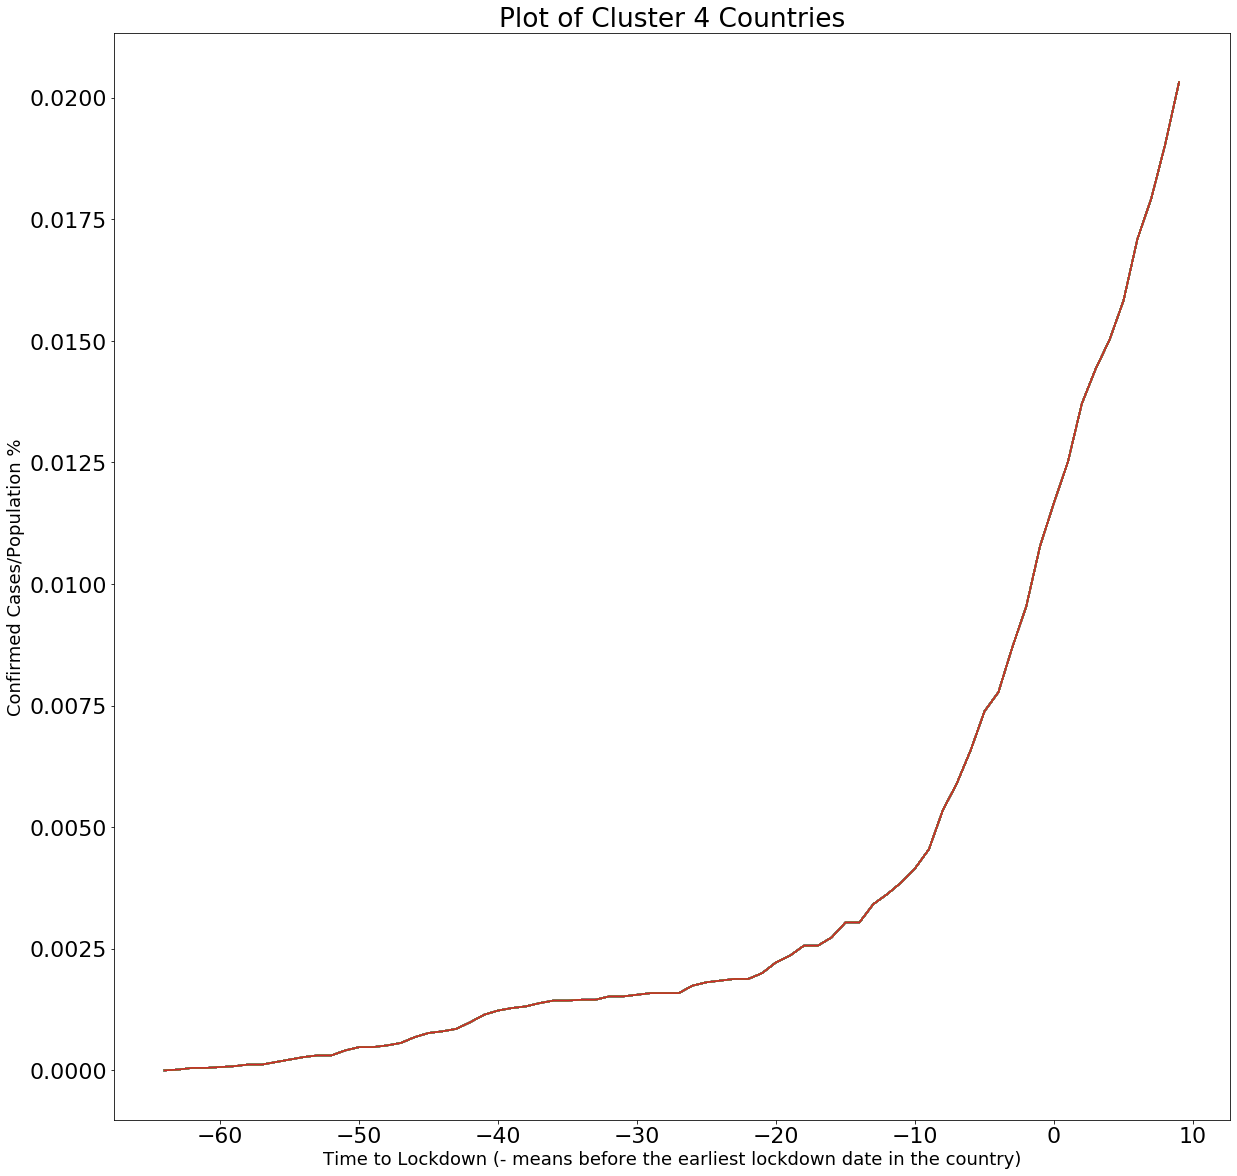

In [380]:
from pylab import rcParams
def plot_clusters(cluster_n, country_demographics_date):
    countries = country_by_date.loc[country_by_date['cluster'] == cluster_n, 'Country_Region']
    for c in countries:
        rcParams['figure.figsize'] = 20, 20
        rcParams.update({'font.size': 22})
        plt.plot(country_demographics_date.loc[country_demographics_date['Country_Region'] == c, 'time to lockdown'],country_demographics_date.loc[country_demographics_date['Country_Region'] == c, 'ConfirmedCases/pop %'])
    plt.title('Plot of Cluster '+str(cluster_n)+' Countries')
    plt.xlabel('Time to Lockdown (- means before the earliest lockdown date in the country)', fontsize=18)
    plt.ylabel('Confirmed Cases/Population %', fontsize=18)
    plt.savefig('Cluster '+str(cluster_n)+' Countries.png')
plot_clusters(4,country_demographics_date)

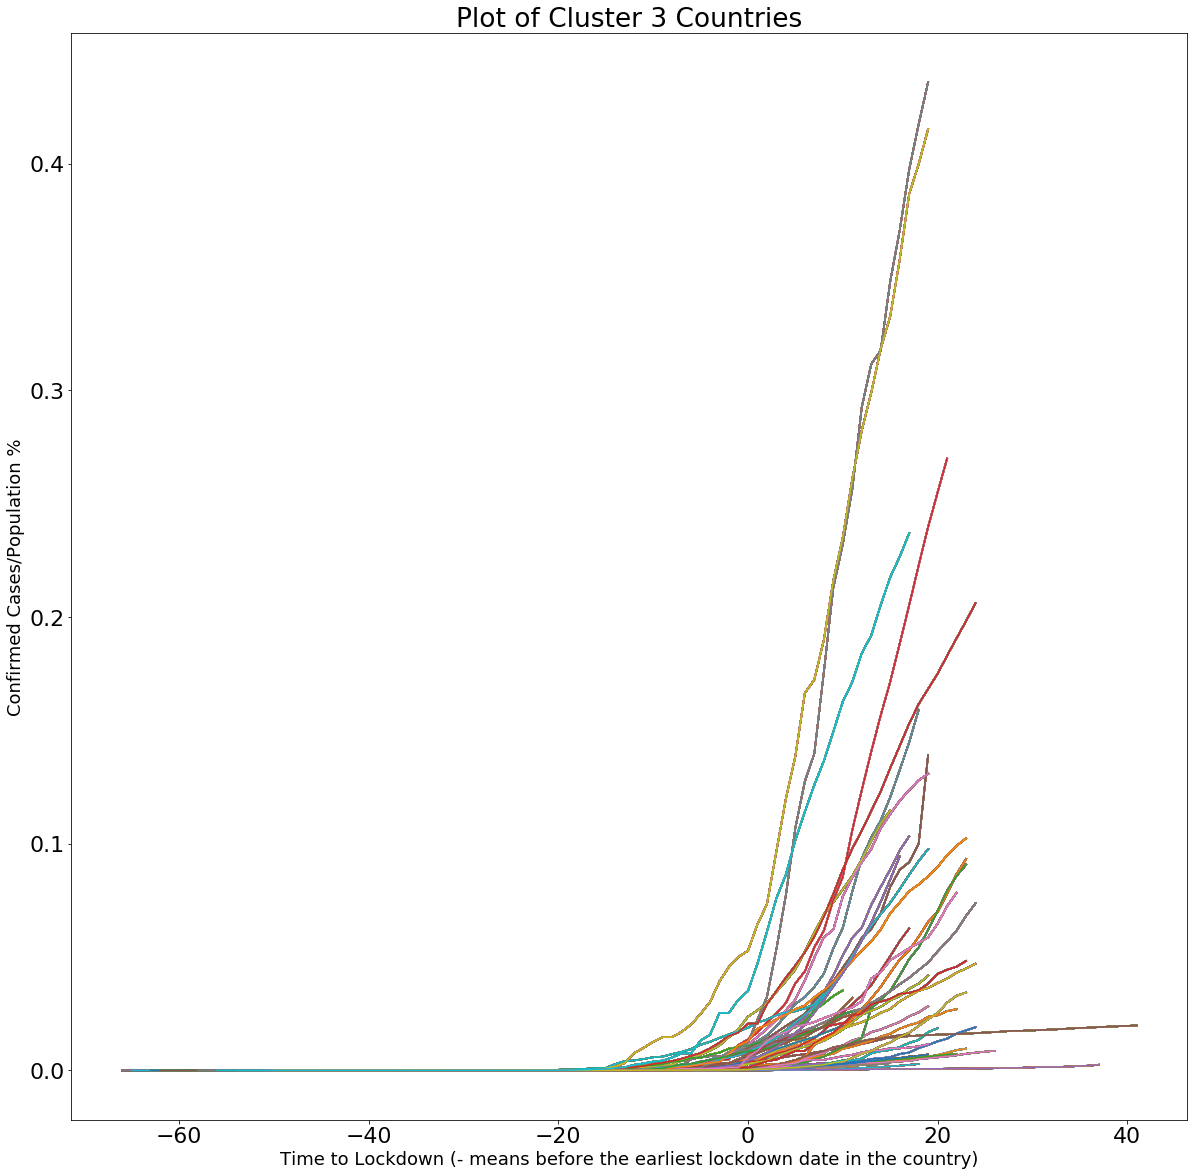

In [381]:
plot_clusters(3,country_demographics_date)

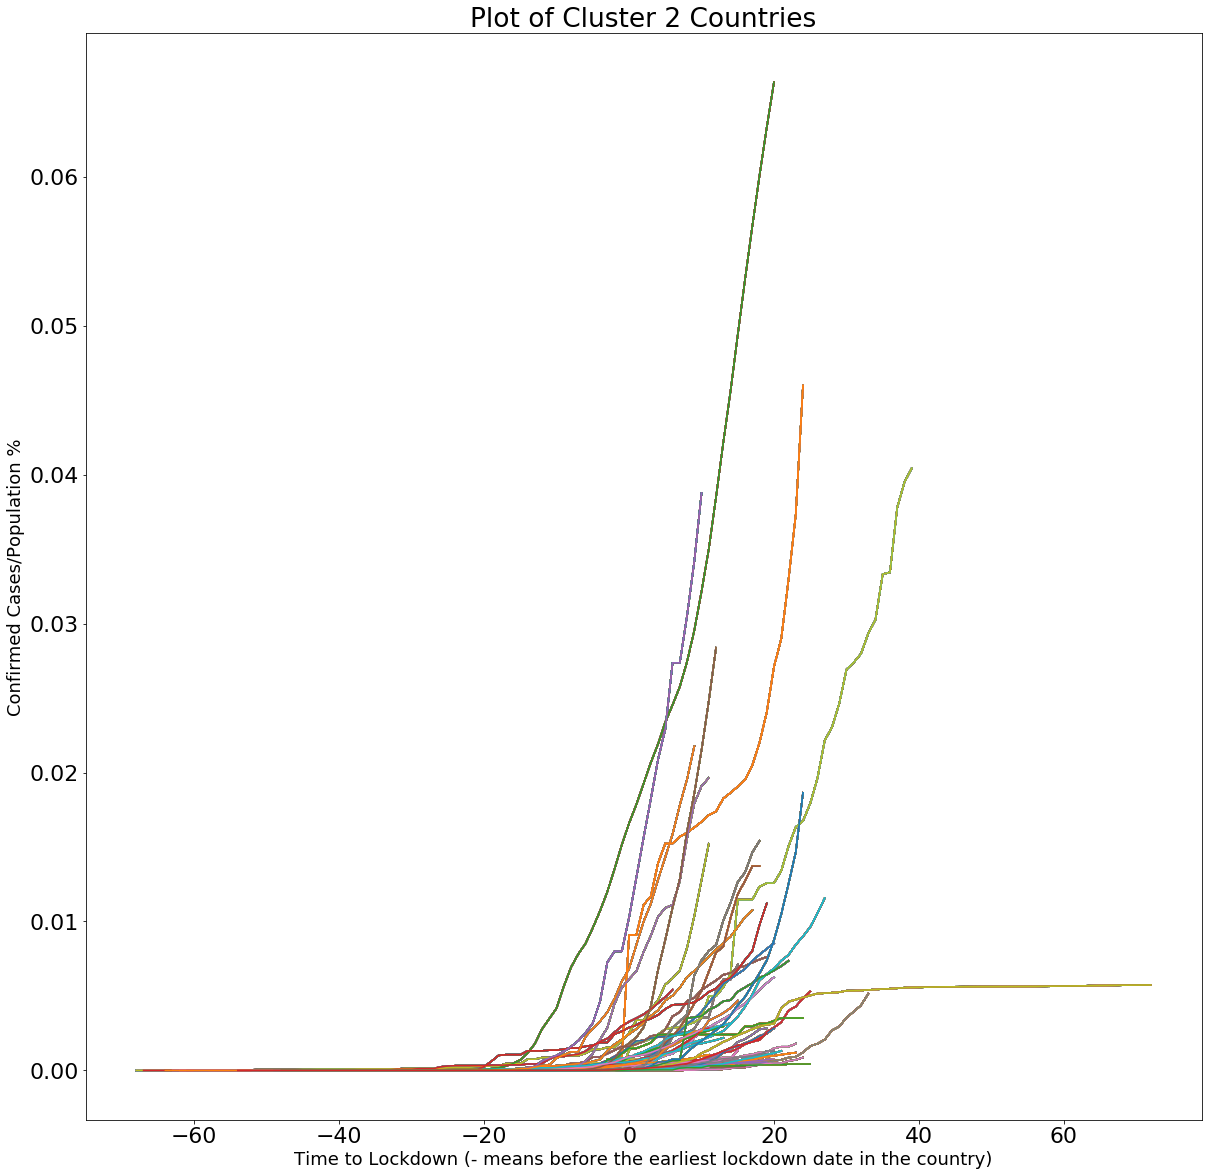

In [382]:
plot_clusters(2,country_demographics_date)

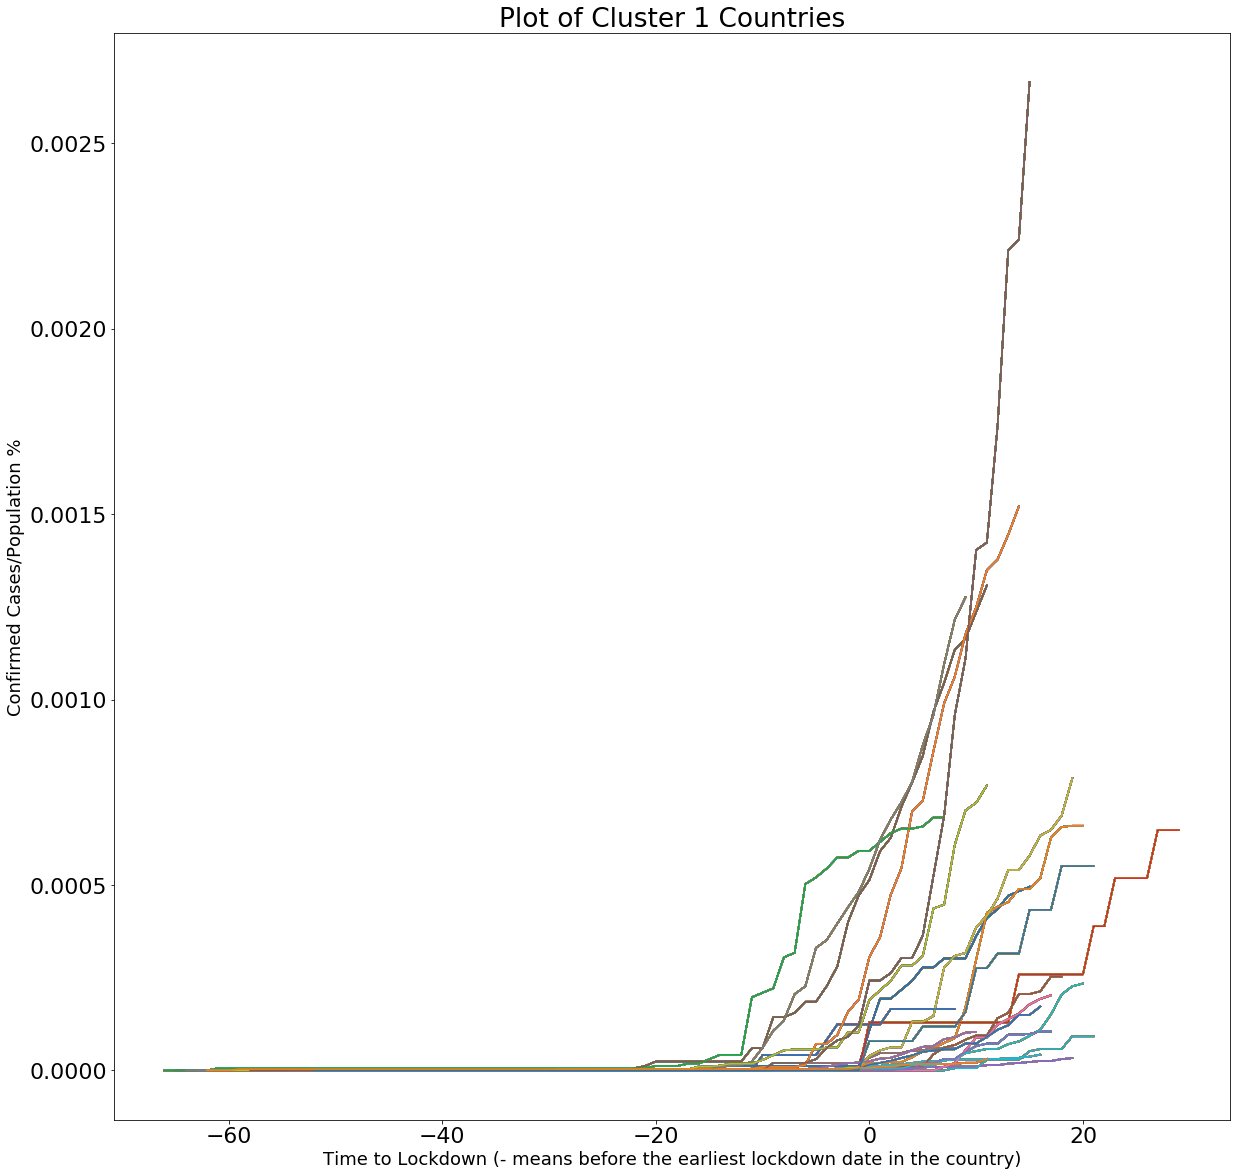

In [383]:
plot_clusters(1,country_demographics_date)